<a href="https://colab.research.google.com/github/Sabya2/Kaggle---Aug---TPS/blob/main/TPS_Aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing 

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Kaggle data/tabular-playground-series-aug-2021/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Kaggle data/tabular-playground-series-aug-2021/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/Kaggle data/tabular-playground-series-aug-2021/sample_submission.csv")

# I'll remove the ID column of both train and test, cause they are of no use here
train.drop(columns = 'id', inplace = True)
test.drop(columns = 'id', inplace =True)

# Check
print('train columns', train.columns)
print('test columns', test.columns)

train columns Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9',
       ...
       'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'loss'],
      dtype='object', length=101)
test columns Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20',
       'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30',
       'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40',
       'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50',
       'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60',
       'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70',
       'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80',
       'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90',
       'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99'],
      dtype='object')

# Steps or Plans for the August TPS 2021
 
* Check out the feature data types and the target feature 
* Watch out for missing values
* Explore the data with some graphs
* Check for outliers or any other anomalies, will update as I proceed with the data exploration
* Transformation based on the anomalies
* Graphs and the data will tell me the type of model(s) I should go for

# Extracting Information

In [ ]:
print('train shape', train.shape)
train.describe()

train shape (250000, 101)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,2.500000e+05,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,0.511213,51.378476,0.107155,0.050010,3595.133426,8.205953,164.508753,0.375533,16.669745,1.190382,0.063664,0.095226,136.746037,8.034918,0.614930,0.752971,8.891112e+06,0.009645,0.041674,0.074226,0.321328,9.928838,3622.094586,7.413526,-0.480271,6.046948,137.635093,47223.903504,5.469358,7.155835,1.206363,6.461029,-0.018490,1.574449,136.830167,173.530314,6.283875,0.157174,0.502435,0.848153,...,68.257992,4.672625,0.214381,1.194280,0.474751,0.216206,0.939638,1.668524,0.918009,68.939811,0.012219,64.709567,2.239319,3.495883,4430.718917,-0.159048,0.734153,6.416185,1.185112,1.973585,0.014504,-0.455453,0.245507,3.893001,4.400483,253.135672,0.258360,7.154004,7.759941,0.581002,4856.812768,22.579100,2.030554,0.079692,1.555097,2.417556,0.537484,1.576900,8.048805,6.813920
std,0.307884,42.396636,1.322200,0.792368,6072.401061,5.475723,183.335563,0.813597,99.758709,0.099700,2.433281,0.935765,14.422095,5.487786,1.619192,0.626172,8.508967e+06,0.103460,0.684975,0.739724,0.337792,5.661423,6328.918702,3.740530,0.712486,3.172873,15.710846,36013.179913,7.716520,3.443207,0.134848,2.451240,0.787275,1.109286,14.816130,201.166381,3.530354,1.728653,1.789297,0.627197,...,35.655549,2.913057,0.101787,0.099982,0.218068,0.098362,0.732696,10.179813,2.854904,38.940318,0.090087,31.343334,0.735150,1.935741,8050.232085,0.840284,3.344094,2.016620,0.101610,0.689412,0.025504,0.228070,0.700630,1.592608,1.089594,338.972888,0.703873,3.698234,11.378365,0.445022,8501.609009,14.849390,0.900211,0.587780,9.253785,0.892563,0.226589,0.646306,5.647368,7.940179
min,-0.069273,-17.000000,-7.895580,-1.475560,-7589.280000,-3.291050,-40.967200,-4.143080,-502.813000,0.934037,-10.261200,-1.858720,108.086000,-2.115510,-8.648960,-1.805330,-1.173084e+06,-0.341300,-2.777610,-3.693950,-0.029620,-0.732186,-10875.700000,0.095849,-1.771980,-2.759340,100.861000,-3391.000000,-4.283380,0.404425,0.842903,-0.883213,-1.824650,-0.431699,105.359000,-29.524300,-2.776090,-13.697300,-5.747540,-1.496630,...,-16.770000,-1.608820,-0.050361,0.791808,-0.025645,-0.059566,-1.625720,-26.624000,-16.388300,-10.036200,-0.294238,-21.852000,-1.267630,-1.041160,-11332.100000,-2.753550,-43.048000,1.143390,0.902514,-0.554585,-0.122903,-0.994638,-1.540880,0.456437,-3.751090,-26.000000,-1.247060,-0.031391,-9.396700,-0.379189,-12695.700000,-4.059170,0.057800,-1.998800,-24.686300,-1.131980,0.005249,-0.646967,-0.842397,0.000000
25%,0.251287,18.000000,-0.611172,-0.719418,163.864750,4.110127,27.894900,-0.026245,-17.392025,1.132640,-1.246857,-0.775796,124.486000,3.917245,-0.552543,0.331163,9.710185e+05,-0.0476

Huge data set, thus a simple describe is not going to captute the full picture, so I'll rather do a Box plot, and see how the data looks. 
* P.S - Any other better method for suggestion

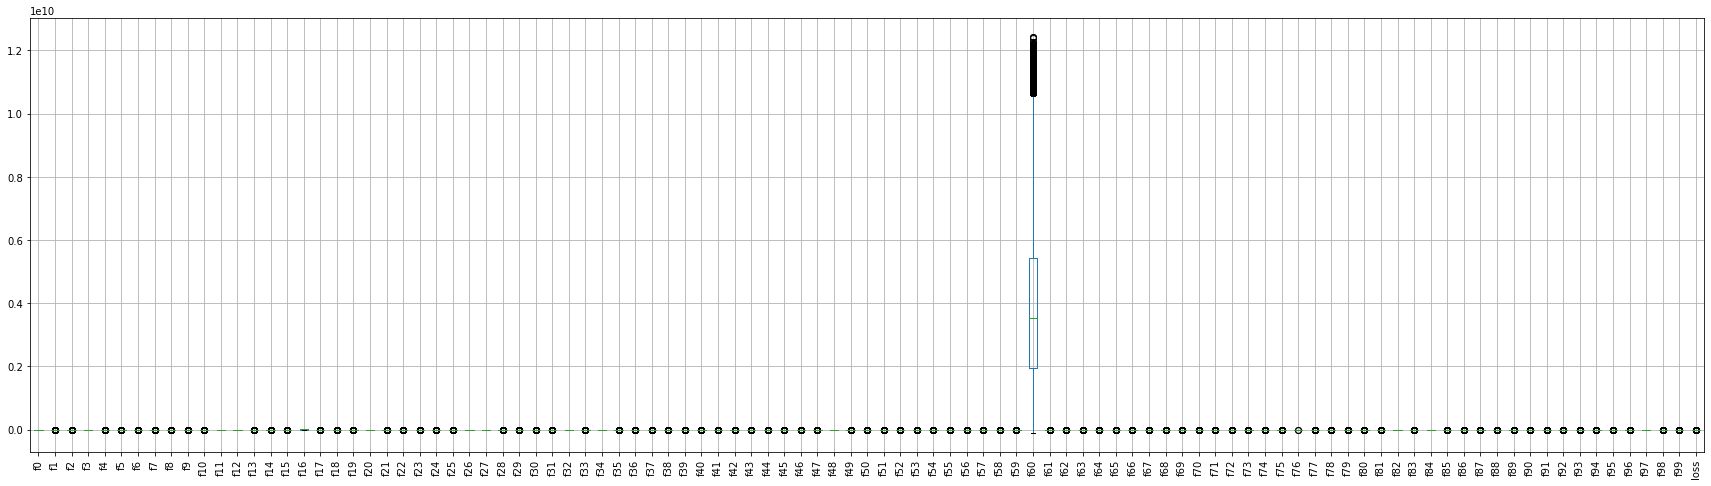

In [ ]:
box = train.boxplot(figsize = (30,8), rot = 90 )

OOPs seems like box plot also gave a pretty weird outcome, any suggestion is welcome
* Conclusion that can be drawn is that, 
  * feature f60 has pretty different scale compared to the rest. 
  * I need to perform some scaling to make the visualisation sensible, but for that i need to know the presence of outliers in the data. 
* Something for later but, i want to see how data model is affected w and w/o any scaling

In [ ]:
# converting the describe table into a spread dataframe 
spread = pd.DataFrame(train.describe().T)

# Calculating the IQR for each feature column
IQR = spread['75%'] - spread['25%']
spread['outliers'] = ( (spread['max'] > (spread['75%'] + 1.5 * IQR)) 
                         | (spread['min'] < (spread['25%'] - 1.5 * IQR)) )

# Outliers count 
spread['outliers_count'] = ((train < (spread['25%'] - 1.5 * IQR)) 
                              | (train > (spread['75%'] + 1.5 * IQR))).sum()

spread.head()

,count,mean,std,min,25%,50%,75%,max,outliers,outliers_count
f0,250000.0,0.511213,0.307884,-0.069273,0.251287,0.514962,0.777323,1.07207,False,0
f1,250000.0,51.378476,42.396636,-17.000000,18.000000,41.000000,75.000000,273.00000,True,6016
f2,250000.0,0.107155,1.322200,-7.895580,-0.611172,0.253815,0.759249,9.76859,True,13479
f3,250000.0,0.050010,0.792368,-1.475560,-0.719418,0.004099,0.765456,1.68019,False,0
f4,250000.0,3595.133426,6072.401061,-7589.280000,163.864750,943.000500,4115.355000,37847.50000,True,29188


Text(0.5, 1.0, 'Feature with Outliers')

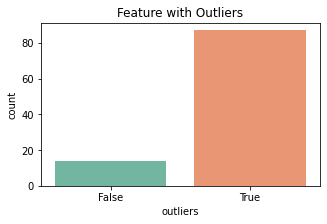

In [ ]:
# Visualising the outliers
plt.figure(figsize=(5,3))
ax = sns.countplot( x="outliers", data=spread, palette="Set2")
ax.set_title("Feature with Outliers")

Well there are multiple features that have outliers, so may be i'll have to tackle the outliers, maybe with min-max scaler or robust scaler.

In [ ]:
# Let's check for Null values 
print('Total Null values:', train.isnull().sum().sum())

Total Null values: 0


luckily no null values 

# Visual Information with graphs 

## Feature distribution



References for the next code cell
* Main code https://www.kaggle.com/c/tabular-playground-series-aug-2021/code 
  * axis.flat - https://towardsdatascience.com/everything-about-plotting-in-python-c12ccdc359bc 
  * More clarification for plotting https://towardsdatascience.com/what-are-the-plt-and-ax-in-matplotlib-exactly-d2cf4bf164a9 , https://towardsdatascience.com/a-step-by-step-guide-for-creating-advanced-python-data-visualizations-with-seaborn-matplotlib-1579d6a1a7d0 
  * Enumerate - https://www.geeksforgeeks.org/enumerate-in-python/ 
  * f-string - for f'f{idx}' : https://www.geeksforgeeks.org/formatted-string-literals-f-strings-python/, thus f'f{idx}' will give f0, f1..f99, since wiht Enumerate the axes gets an index to each value/feature which is used to get the number of the features
  * Spacing - https://www.geeksforgeeks.org/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python/


In [ ]:
fig, axes = plt.subplots(10,10,figsize=(15,12))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    sns.kdeplot(data=train, x=f'f{idx}', 
                fill=True, 
                ax=ax)
    # sns.kdeplot(data=test, x=f'f{idx}', 
                # fill=True, 
                # ax=ax)
    ax.set_xticks([])
    # ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(False)
    ax.set_title(f'f{idx}', loc='right', weight='bold', fontsize=10)

# fig.supxlabel('Average by class (by feature)', ha='center', fontweight='bold')
# wont work because of the matplotlip version 
# plt.subplot_tool()
fig.tight_layout()
plt.show()
    

Question::: Why is loss not being plotted???
is it because of the net subplot isze is for 100 plots ??

### Inference
Thanks to the huge feature numbers, visualising them together is a daunting task. Anyways, couple of thing:
  * Aligning with the outliers calculation, the good number of data is out of normal, with hint of skewness
  * I plotted the data wiht their y axis, to get a better understanding of the scaling, and yeah, scaling has to be done. Well as mentioned previously I'll perform std scalar and robust scalar to see how they effect the model. 


##Rescale the data and plot the same graph to see any changes

In [ ]:
# Robust Scaling
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler() # class object
rscale_train = pd.DataFrame(scaler.fit_transform(train), columns = train.columns)


# scaled data plot 

fig, axes = plt.subplots(10,10,figsize=(15,12))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    sns.kdeplot(data=rscale_train, x=f'f{idx}', 
                fill=True, 
                ax=ax)
    # sns.kdeplot(data=test, x=f'f{idx}', 
                # fill=True, 
                # ax=ax)
    ax.set_xticks([])
    # ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(False)
    ax.set_title(f'f{idx}', loc='right', weight='bold', fontsize=10)

# fig.supxlabel('Average by class (by feature)', ha='center', fontweight='bold')
# wont work because of the matplotlip version 
# plt.subplot_tool()
# plt.title("Robust scale data plot")
fig.suptitle('Robust scale data plot')
fig.tight_layout()
plt.show()

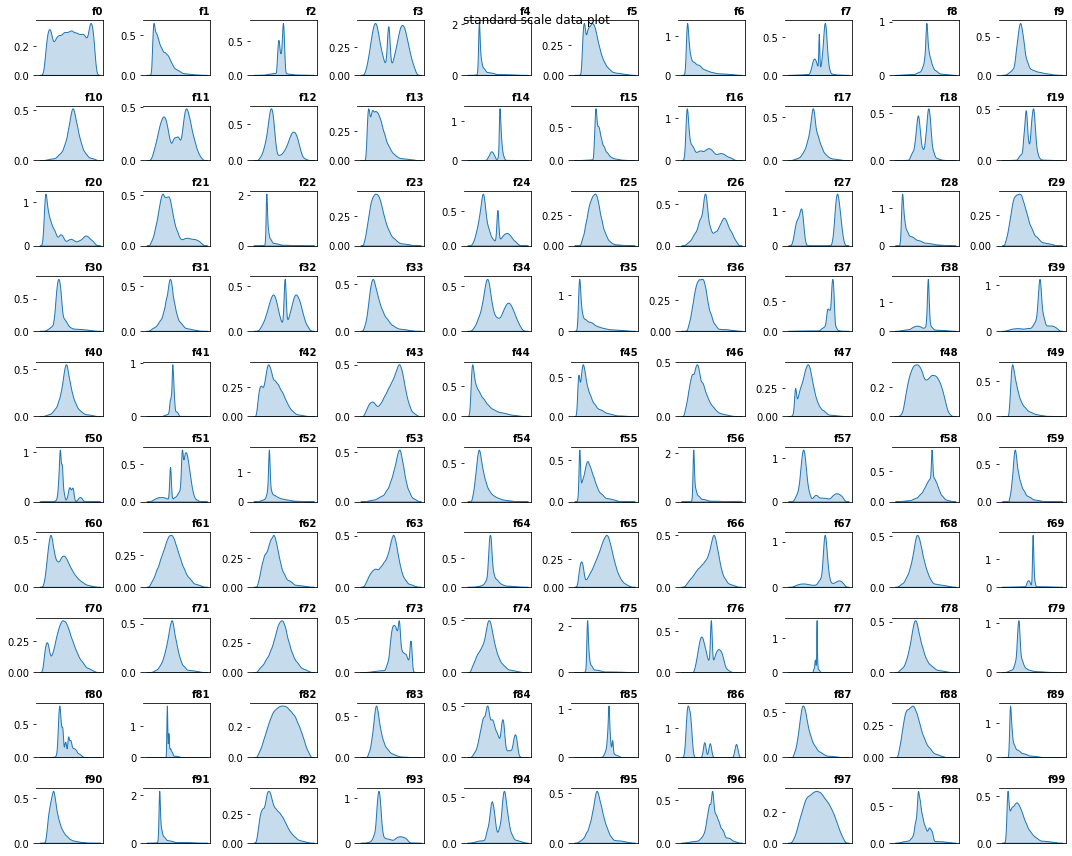

In [ ]:
# Standard scaling
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
features = [f'f{i}' for i in range(100)] # feature name list 
s_scale_train = pd.DataFrame(ss.fit_transform(train.drop('loss', axis = 1)), columns = train.columns[:-1])
# test[features] = ss.transform(test[features])

# scaled data plot 

fig, axes = plt.subplots(10,10,figsize=(15,12))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    sns.kdeplot(data=s_scale_train, x=f'f{idx}', 
                fill=True, 
                ax=ax)
    # sns.kdeplot(data=test, x=f'f{idx}', 
                # fill=True, 
                # ax=ax)
    ax.set_xticks([])
    # ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(False)
    ax.set_title(f'f{idx}', loc='right', weight='bold', fontsize=10)

# fig.supxlabel('Average by class (by feature)', ha='center', fontweight='bold')
# wont work because of the matplotlip version 
# plt.subplot_tool()
# plt.title("Robust scale data plot")
fig.suptitle('standard scale data plot')
fig.tight_layout()
plt.show()

shape of the data doesnot changes after transformation

## Target distribution

Lets check out the traget 

with scalar and robust scaled data i'll try multivariate regression

# Correlation of features

In [ ]:
# pair plot 
# sns.pairplot(train)

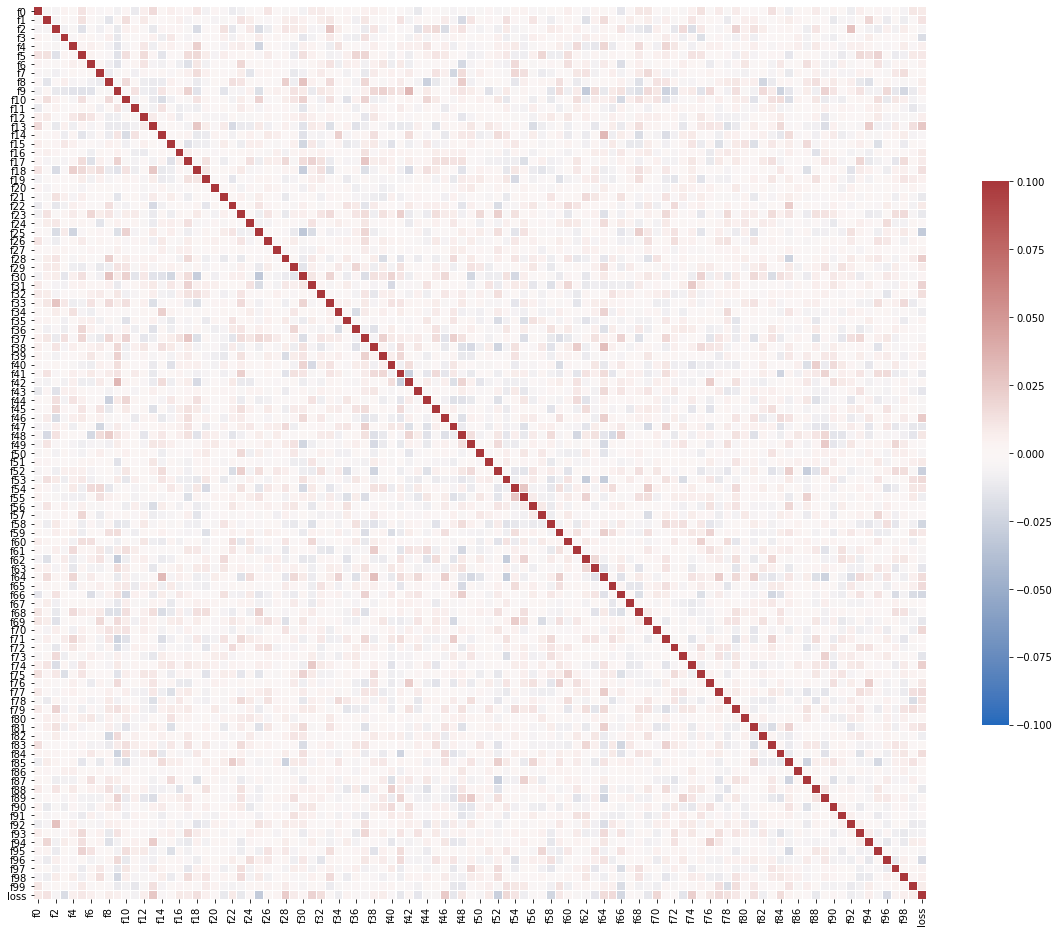

In [ ]:
# Correlation with pearson corr 

plt.figure(figsize=(20,20))
sns.heatmap(train.corr(), 
            annot=False, cmap="vlag",
            center = 0, linewidths=0.01,
            cbar_kws={"shrink": .5}, square = True, vmin=-0.1, vmax=0.1) 

Inference
* Well the features are too less correlated, both positively and negatively with each other and the target, also the festures are lot less normally distributed, so I'll spearman, lets see if i get some changes.

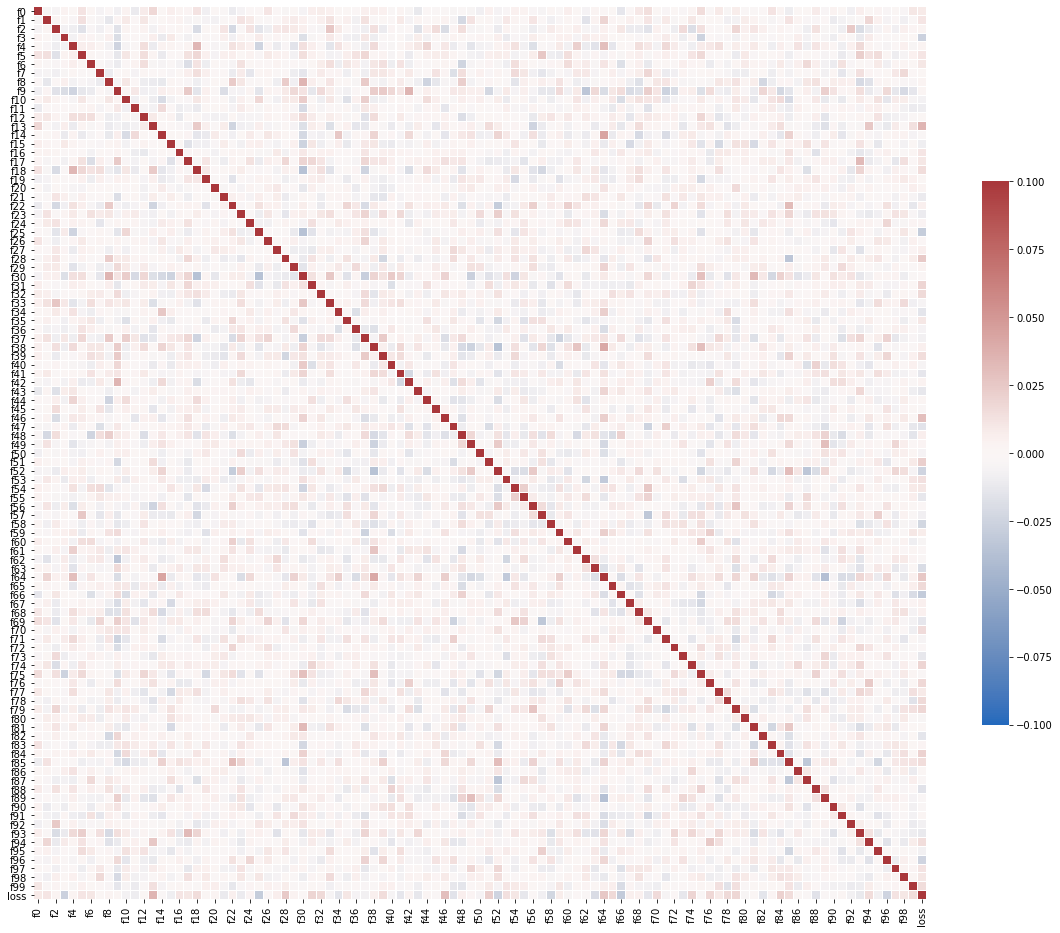

In [ ]:
# Correlation with spearman corr
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(method = 'spearman'), 
            annot=False, cmap="vlag",
            center = 0, linewidths=0.01,
            cbar_kws={"shrink": .5}, square = True, vmin=-0.1, vmax=0.1) 

Inference: 
* Prformed correaltion with soearman since a lot of features are not normal in nature but all in vain, still i think spearman will be better form, since the data is not normally distributed. 
* Both the heatmaps dont have much of difference, i was expecting better correlation due to the data nature. 
* So the feature selection for Regression haa to be performed using mutual info 

# Model Creation


## Linear Model creation 

### Feature selection 

Prior to feature selection need to sepearte the target and features

* x = train.iloc[: ,:-1]
* y = train.iloc[:,-1]

In [ ]:
# Splitting
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train.iloc[: ,:-1], train.iloc[:,-1], 
                                                    test_size=0.4, random_state=2)
print("X-train shape", x_train.shape, "\nY-test shape" ,y_test.shape)

X-train shape (150000, 100) 
Y-test shape (100000,)


* So in order to perform multiple linear regression, I need to select which all features will i use. Now here is the catch, for feature selection, i can use  spearman correlation , since most of the data has outliers and no normal distribution, caveates for pearson correlation. https://towardsdatascience.com/pearson-and-spearman-rank-correlation-coefficient-explained-60811e61185a, https://towardsdatascience.com/pearson-coefficient-of-correlation-explained-369991d93404
* The other method is via Mutual infomration. https://machinelearningmastery.com/feature-selection-for-regression-data/, https://towardsdatascience.com/how-to-perform-feature-selection-for-regression-problems-c928e527bbfa
* I'will be going with Mutual Info, since the heatmaps are not giving me suffcient confidence. 

In [ ]:
# Feature selection with Mutual Information
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# feature selection
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')

# learn relationship from training data
f_selector.fit(x_train, y_train)

# transform train input data
x_train_fs = f_selector.transform(x_train)

# transform test input data
x_test_fs = f_selector.transform(x_test)

# Plot the scores for the features
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel("feature index")
plt.ylabel("Estimated MI value")
plt.show()


Couldn't run mutula info, due to unavailable ram

## Random Forest 1.0: baseline

In [ ]:
# Splitting
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train.iloc[: ,:-1], train.iloc[:,-1], 
                                                    test_size=0.4, random_state=2)
print("X-train shape", x_train.shape, "\nY-test shape" ,y_test.shape)

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor()
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# Use the forest's predict method on the test data
y_pred = rf.predict(x_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Base line Mean Absolute Error', round(np.mean(errors), 2), 'degrees.')

Base line Mean Absolute Error 6.33 degrees.


In [ ]:
submission['loss'] = rf.predict(test)
submission

,id,loss
0,250000,6.79
1,250001,8.05
2,250002,8.74
3,250003,5.63
4,250004,8.09
...,...,...
149995,399995,7.51
149996,399996,6.36
149997,399997,6.55
149998,399998,7.09


Need to improve the hyperparameters of the data
https://medium.com/@ODSC/optimizing-hyperparameters-for-random-forest-algorithms-in-scikit-learn-d60b7aa07ead, https://towardsdatascience.com/random-forest-hyperparameters-and-how-to-fine-tune-them-17aee785ee0d, https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-sklearn-ensemble-learning-bagging-and-random-forests
* Now someone with higher computing power can try muotiple combination, i
'll fix teh features on a whim. 

## random forest: parameter tuning

In [ ]:
# Splitting
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train.iloc[: ,:-1], train.iloc[:,-1], 
                                                    test_size=0.4, random_state=2)
print("X-train shape", x_train.shape, "\nY-test shape" ,y_test.shape)

X-train shape (150000, 100) 
Y-test shape (100000,)


In [ ]:
# Max number of trees
n_estimators = [100, 200]

# Tree depth
max_depth = [10,15]

# Min samples for a node to split
min_samples_split = [25, 50]

# Min samples at the leaf node after split
min_samples_leaf = [5, 10]

In [ ]:
params = {'n_estimators': n_estimators,
          'max_depth': max_depth,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf } 
         


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(random_state = 5)

rf_regressor_random = RandomizedSearchCV(estimator = rf, 
                                         param_distributions = params, 
                                         n_jobs=-1, cv=3, verbose = 2,
                                         random_state = 5 )
rf_regressor_random.fit(x_train, y_train)

print('Best Parameters : ',rf_regressor_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:

print('Best Parameters : ',rf_regressor_random.best_params_)

## RF with param 2.0

In [ ]:
# Splitting
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train.iloc[: ,:-1], train.iloc[:,-1], 
                                                    test_size=0.4, random_state=2)
print("X-train shape", x_train.shape, "\nY-test shape" ,y_test.shape)

X-train shape (150000, 100) 
Y-test shape (100000,)


* Max number of trees
n_estimators = [100, 200]

* Tree depth
max_depth = [10,15]

* Min samples for a node to split
min_samples_split = [25, 50]

* Min samples at the leaf node after split
min_samples_leaf = [5, 10]

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=200, max_depth = 10, 
                           min_samples_split = 25, min_samples_leaf = 5,
                           verbose = 1)

# Train the model on training data
rf.fit(x_train, y_train)

# Use the forest's predict method on the test data
y_pred = rf.predict(x_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Base line Mean Absolute Error', round(np.mean(errors), 2), 'degrees.')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 47.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Base line Mean Absolute Error 6.18 degrees.


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.2s finished


## RF Param 2.1

In [ ]:
# Splitting
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train.iloc[: ,:-1], train.iloc[:,-1], 
                                                    test_size=0.4, random_state=2)
print("X-train shape", x_train.shape, "\nY-test shape" ,y_test.shape)

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=200, max_depth = 20, 
                           min_samples_split = 50, min_samples_leaf = 10,
                           verbose = 1)

# Train the model on training data
rf.fit(x_train, y_train)

# Use the forest's predict method on the test data
y_pred = rf.predict(x_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Base line Mean Absolute Error', round(np.mean(errors), 2), 'degrees.')


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 77.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Base line Mean Absolute Error 6.18 degrees.


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.5s finished


In [ ]:
# Print out the mean absolute error (mae)
print('Base line Mean Absolute Error', round(np.mean(errors), 4), 'degrees.')

Base line Mean Absolute Error 6.177 degrees.


## Rf param 2.2

In [ ]:
# Splitting
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train.iloc[: ,:-1], train.iloc[:,-1], 
                                                    test_size=0.4, random_state=2)
print("X-train shape", x_train.shape, "\nY-test shape" ,y_test.shape)

X-train shape (150000, 100) 
Y-test shape (100000,)


In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Initantiate model with 500 decision trees
rf = RandomForestRegressor(n_estimators=500, max_depth = 20, 
                           min_samples_split = 50, min_samples_leaf = 10,
                           verbose = 1)

# Train the model on training data
rf.fit(x_train, y_train)

# Use the forest's predict method on the test data
y_pred = rf.predict(x_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Base line Mean Absolute Error', round(np.mean(errors), 4), 'degrees.')


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 193.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Base line Mean Absolute Error 6.1742 degrees.


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   11.2s finished


In [ ]:
submission['loss'] = rf.predict(test)
submission
submission.to_csv("submission_rf2.2.csv")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   16.1s finished


,id,loss
0,250000,7.078445
1,250001,6.798377
2,250002,6.646562
3,250003,6.350316
4,250004,7.369272
...,...,...
149995,399995,7.074968
149996,399996,6.717687
149997,399997,6.355458
149998,399998,6.134388


In [ ]:
submission1 = pd.read_csv('/content/submission_rf2.2.csv')

In [ ]:
submission1.drop(columns = 'Unnamed: 0', inplace  = True)

In [ ]:
submission1.to_csv('submission_rf2.csv', index = False)

# keep the runtime open

(# comand +option +i)

function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,120000);

# Dimension Reductionality

With the help of PCA i'll reduce the dimensions of the and then check the correlation and model for prediction


Steps of PCA
* Splitting
* Standarisation
* PCA https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python


In [ ]:
# Splitting
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( train.iloc[: ,:-1], train.iloc[:,-1], 
                                                    test_size=0.2, random_state=2)
print("X-train shape", x_train.shape, "\nY-test shape" ,y_test.shape)

# Standard scaling
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
x_train = pd.DataFrame(ss.fit_transform(x_train))
x_test = pd.DataFrame(ss.fit_transform(x_test))

X-train shape (200000, 100) 
Y-test shape (50000,)


In [ ]:
# making sure that mean is 0

print(x_train.mean().sum())
print(x_test.mean().sum())

-1.2129777564318108e-15
-3.1159778229872267e-15


## pca default

In [ ]:
# PCA
from sklearn.decomposition import PCA
pca = PCA()
pca_train = pca.fit_transform(x_train)

In [ ]:
pca_train = pd.DataFrame(pca_train)
list_name = [f'pc{i}' for i in range(100)]
pca_train.columns = list_name
pca_train


## Number of PC
A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components

* https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html


In [ ]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.01233764, 0.01203594, 0.01177884, 0.01166103, 0.01165398,
       0.01153597, 0.01134726, 0.01126693, 0.01122782, 0.01116048,
       0.01110284, 0.01106751, 0.01103489, 0.01091206, 0.01086043,
       0.01082844, 0.01078221, 0.01073624, 0.01072728, 0.01070806,
       0.01063748, 0.01060454, 0.01053135, 0.01052571, 0.01045666,
       0.01043383, 0.01042267, 0.01040123, 0.01036672, 0.01031513,
       0.0102983 , 0.01027848, 0.01023785, 0.01021943, 0.01021045,
       0.01018356, 0.01014833, 0.01013891, 0.010129  , 0.01011336,
       0.01008648, 0.01008301, 0.01005011, 0.01000533, 0.00999697,
       0.00997836, 0.00994146, 0.00991805, 0.00989941, 0.00987299,
       0.00985075, 0.00984396, 0.00983715, 0.00981478, 0.00978883,
       0.00978246, 0.00975814, 0.00973694, 0.00971438, 0.00968819,
       0.0096665 , 0.00965468, 0.00964796, 0.00962819, 0.00960044,
       0.0095864 , 0.00957647, 0.0095443 , 0.0095326 , 0.00950919,
       0.00949046, 0.00947163, 0.00943676, 0.00942907, 0.00940

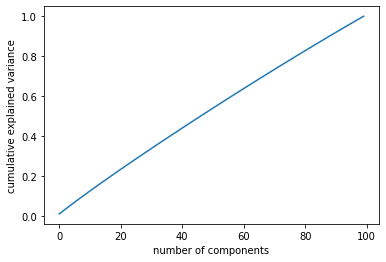

In [ ]:
plt.plot(np.cumsum(explained_variance))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### PCA 0.95
https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [ ]:

from sklearn.decomposition import PCA
pca1 = PCA(0.95)
pca_train1 = pca1.fit(x_train)

NameError: ignored

In [ ]:
explained_variance = pca1.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

AttributeError: ignored

### PCA 
n_components = 10, 50


In [ ]:
from sklearn.decomposition import PCA
pca1 = PCA(n_components = 50)
pca_train1 = pca1.fit(x_train)

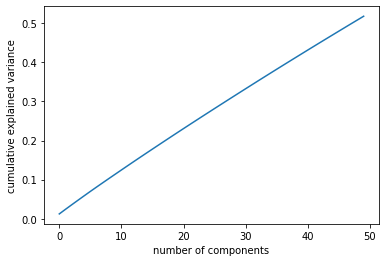

In [ ]:
explained_variance = pca1.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## inference

Well in the data lacked collinearity to a great extent, PCA also i doubt will be abe to yield a better result. the above PCA cells indicate that expalained variance didn't improve after all

# Model With PCA = 50

## Setting up PCA

In [ ]:
# Splitting
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( train.iloc[: ,:-1], train.iloc[:,-1], 
                                                    test_size=0.2, random_state=2)
print("X-train shape", x_train.shape, "\nY-test shape" ,y_test.shape)

# Standard scaling
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
x_train = pd.DataFrame(ss.fit_transform(x_train))
x_test = pd.DataFrame(ss.fit_transform(x_test))

NameError: ignored

In [ ]:
# PCA = 50
from sklearn.decomposition import PCA
pca = PCA(n_components = 50)
pca_train = pca.fit_transform(x_train)
pca_test = pca.transform(x_test)
pred_test = pca.transform(test)

In [ ]:
pred_test1 = pca.fit_transform(test)

In [ ]:
pca_train = pd.DataFrame(pca_train)
list_name = [f'pc{i}' for i in range(50)]
pca_train.columns = list_name

these are called as spree plots: https://medium.com/@sercandogan/why-scree-plot-is-important-in-pca-a66cd7dcd624

In [ ]:
explained_variance = pca.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## RF model

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Initantiate model with 500 decision trees
rf = RandomForestRegressor(n_estimators=500, max_depth = 20, 
                           min_samples_split = 50, min_samples_leaf = 10,
                           verbose = 1)

# Train the model on training data
rf.fit(pca_train, y_train)



NameError: ignored

In [ ]:
# Use the forest's predict method on the test data
y_pred = rf.predict(pca_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Base line Mean Absolute Error', round(np.mean(errors), 4), 'degrees.')


In [ ]:
# fit transforming the test data set

submission['loss'] = rf.predict(pred_test1)
submission.to_csv("submission_rf_pca_fit_transform.csv", index = False)

In [ ]:
submission['loss'] = rf.predict(pred_test)
submission.to_csv("submission_rf_pca.csv", index = False)

Well a sad thing happened, the PCA didn't help much, the error calculated wasn't good enough. If i increase the features, it defeats the purpose of PCA. Kry take away: PCA will work better of the data shows multicollinearity. 



# Model with Light GBM

In [ ]:
# Splitting
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( train.iloc[: ,:-1], train.iloc[:,-1], 
                                                    test_size=0.2, random_state=2)
print("X-train shape", x_train.shape, "\nY-test shape" ,y_test.shape)

X-train shape (200000, 100) 
Y-test shape (50000,)


## Base Model

In [ ]:
model = lgb.LGBMRegressor()
model.fit(x_train, y_train)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# Use the forest's predict method on the test data
y_pred = model.predict(x_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Base line Mean Absolute Error', round(np.mean(errors), 4), 'degrees.')
# Print score top check overfiting
print("train Score -", model.score(x_train,y_train))
print("test Score -", model.score(x_test,y_test))

Base line Mean Absolute Error 6.1792 degrees.
train Score - 0.06259003026507326
test Score - 0.01890684026810585


the scores are compatable, thus not overfitting

## parametric tuning
https://www.kaggle.com/lasmith/house-price-regression-with-lightgbm


### lgbm 1.0

In [ ]:
model = lgb.LGBMRegressor(num_leaves = 50, n_estimators=500, random_state = 2 )
model.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=50, objective=None,
              random_state=2, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# Use the forest's predict method on the test data
y_pred = model.predict(x_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Base line Mean Absolute Error', round(np.mean(errors), 4), 'degrees.')
# Print score top check overfiting
print("train Score -", model.score(x_train,y_train))
print("test Score -", model.score(x_test,y_test))

Base line Mean Absolute Error 6.1885 degrees.
train Score - 0.2935958904904493
test Score - 0.009871769304065081


### lgbm 2.0

In [ ]:
model = lgb.LGBMRegressor(n_estimators=500, random_state = 2 )
model.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=2, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# Use the forest's predict method on the test data
y_pred = model.predict(x_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Base line Mean Absolute Error', round(np.mean(errors), 4), 'degrees.')
# Print score top check overfiting
print("train Score -", model.score(x_train,y_train))
print("test Score -", model.score(x_test,y_test))

Base line Mean Absolute Error 6.1762 degrees.
train Score - 0.2002080116856917
test Score - 0.016337712784154967


### lgbm 3.0

In [ ]:
model = lgb.LGBMRegressor(n_estimators=200, max_depth =20 , random_state = 2 )
model.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=20,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
              random_state=2, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# Use the forest's predict method on the test data
y_pred = model.predict(x_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Base line Mean Absolute Error', round(np.mean(errors), 4), 'degrees.')
# Print score top check overfiting
print("train Score -", model.score(x_train,y_train))
print("test Score -", model.score(x_test,y_test))

Base line Mean Absolute Error 6.1732 degrees.
train Score - 0.10230264974872007
test Score - 0.01912578662861375


### lgbm 4.0

In [ ]:
model = lgb.LGBMRegressor(num_iteration =500,  learning_rate=0.05, n_estimators=200, 
                          max_depth = 10 , random_state = 2 )
model.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_iteration=500, num_leaves=31,
              objective=None, random_state=2, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [ ]:
# Use the forest's predict method on the test data
y_pred = model.predict(x_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Base line Mean Absolute Error', round(np.mean(errors), 4), 'degrees.')
# Print score top check overfiting
print("train Score -", model.score(x_train,y_train))
print("test Score -", model.score(x_test,y_test))

Base line Mean Absolute Error 6.1717 degrees.
train Score - 0.11941161526461753
test Score - 0.019767842871647567


### lgbm 5.0

In [ ]:
model = lgb.LGBMRegressor(num_iteration =800,  learning_rate=0.05, n_estimators=200, 
                          max_depth = 10 , random_state = 2 )
model.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_iteration=800, num_leaves=31,
              objective=None, random_state=2, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [ ]:
# Use the forest's predict method on the test data
y_pred = model.predict(x_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Base line Mean Absolute Error', round(np.mean(errors), 4), 'degrees.')
# Print score top check overfiting
print("train Score -", model.score(x_train,y_train))
print("test Score -", model.score(x_test,y_test))

Base line Mean Absolute Error 6.1699 degrees.
train Score - 0.16936489227814466
test Score - 0.019311624102274383


### lgbm 6.0

In [ ]:
model = lgb.LGBMRegressor(num_iteration = 800,  learning_rate=0.03, n_estimators=150, 
                           max_depth = 5, random_state = 10 )
model.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.03, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=150, n_jobs=-1, num_iteration=800, num_leaves=31,
              objective=None, random_state=10, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [ ]:
# Use the forest's predict method on the test data
y_pred = model.predict(x_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Base line Mean Absolute Error', round(np.mean(errors), 4), 'degrees.')
# Print score top check overfiting
print("train Score -", model.score(x_train,y_train))
print("test Score -", model.score(x_test,y_test))

Base line Mean Absolute Error 6.1627 degrees.
train Score - 0.09648004377545671
test Score - 0.02170096543853095


### LGBM 7.0 with random search cv


In [ ]:
n_estimators = [100, 200, 300, 500, 800, 900]

num_leaves = [30, 50, 80, 100, 150]

random_state = [2, 5, 20]

max_depth = [10, 20, 50, 100]

learning_rate = [0.01, 0.02, 0.03, 0.05, 0.1]

num_iteration = [200, 500, 600, 800, 1000]


In [ ]:
# Dictionary of parameters

params = {'n_estimators': n_estimators,
          'num_leaves': num_leaves,
          'random_state': random_state,
          'max_depth': max_depth, 
          'learning_rate': learning_rate, 
          'num_iteration': num_iteration
          } 

In [ ]:
x = train.iloc[:,:-1]
y = train['loss']

In [ ]:

# create model
model = lgb.LGBMRegressor()

r_search = RandomizedSearchCV(estimator = model, param_distributions = params, 
                              cv = 3, scoring ='neg_mean_absolute_error', 
                              n_iter = 5, verbose=1, return_train_score=True)

r_search.fit(x,y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/lo

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silen...
                   iid='deprecated', n_iter=5, n_jobs=None,
                   param_distributions={'learning_rate': [0.01, 0.02, 0.03,


In [ ]:
print('Best parameters', r_search.best_params_)
print('Best score', -r_search.best_score_)

Best parameters {'random_state': 2, 'num_leaves': 100, 'num_iteration': 600, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.03}
Best score 6.115771005484581


In [ ]:
model = lgb.LGBMRegressor(num_iteration =600, num_leaves = 100, max_depth = 10, learning_rate = 0.03,
                          n_estimators = 200, random_state = 2 )
  
model.fit(x,y)

submission["loss"] = model.predict(test)
submission.to_csv('submission-> rn + iter full cv.csv', index = False)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
print('Best parameters', r_search.best_params_)
print('Best score', -r_search.best_score_)

Best parameters {'random_state': 5, 'num_leaves': 80, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.03}
Best score 6.113299316682611


In [ ]:
model = lgb.LGBMRegressor(num_leaves = 80, max_depth = 10, learning_rate = 0.03,
                          n_estimators = 300, random_state = 5 )
  
model.fit(x,y)

submission["loss"] = model.predict(test)
submission.to_csv('submission-> rn cv.csv', index = False)

In [ ]:
model = lgb.LGBMRegressor(num_iteration =800, num_leaves = 80, max_depth = 10, learning_rate = 0.03,
                          n_estimators = 300, random_state = 5 )
  
model.fit(x,y)

submission["loss"] = model.predict(test)
submission.to_csv('submission-> rn + iter cv.csv', index = False)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


### LGBM 8.0 last try

In [ ]:
x = train.iloc[:,:-1]
y = train['loss']

In [ ]:
model = lgb.LGBMRegressor(num_iteration =800, num_leaves = 100, max_depth = 10, learning_rate = 0.03,
                          n_estimators = 300, random_state = 5 )
  
model.fit(x,y)

submission["loss"] = model.predict(test)
submission.to_csv('submission-> last try combine all effects.csv', index = False)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [ ]:
|